In [144]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from tqdm import tqdm
from pylab import *

In [145]:
print(os.listdir('../../data/KMNIST/raw')) 

['t10k-labels-idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-images-idx3-ubyte']


In [146]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.KMNIST(root='../../data',      
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.KMNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)



In [71]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.fc1=nn.Linear(input_size,hidden_size)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden_size,num_classes)
        
    def forward(self,x):
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        return out
    
model=NeuralNet(input_size,hidden_size,num_classes).to(device)

#loss and optimiser
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)        

In [147]:

class Kuzushiji(nn.Module):
    def __init__(self):
        super(Kuzushiji, self).__init__()
        self.pad1 = nn.ZeroPad2d((2, 2))
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7, 7), stride=(1, 1), bias=False), 
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.ReLU()
        )
    
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=(1, 1), bias=False), 
        nn.BatchNorm2d(num_features=64),
        nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), bias=False), 
        nn.BatchNorm2d(num_features=128),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.ReLU()
        )
        
        self.fc1 = nn.Sequential(
        nn.Linear(in_features=768, out_features=512),
        nn.ReLU()
        )
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.fc2 = nn.Sequential(
        nn.Linear(in_features=512, out_features=10),
        nn.Softmax()
        )
    def forward(self, x):
        x = self.pad1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.shape[0], -1)
       # print(x.shape)
        x = self.fc1(x)
        x = self.dropout1(x)
        out = self.fc2(x)
        
        return out

In [148]:
my_model=Kuzushiji().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(my_model.parameters(),lr=learning_rate)

In [149]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 1, 28,28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = my_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/5], Step [100/600], Loss: 1.5815
Epoch [1/5], Step [200/600], Loss: 1.5373
Epoch [1/5], Step [300/600], Loss: 1.5530
Epoch [1/5], Step [400/600], Loss: 1.5325
Epoch [1/5], Step [500/600], Loss: 1.5769
Epoch [1/5], Step [600/600], Loss: 1.6092
Epoch [2/5], Step [100/600], Loss: 1.5143
Epoch [2/5], Step [200/600], Loss: 1.5594
Epoch [2/5], Step [300/600], Loss: 1.5302
Epoch [2/5], Step [400/600], Loss: 1.5024
Epoch [2/5], Step [500/600], Loss: 1.5018
Epoch [2/5], Step [600/600], Loss: 1.5138
Epoch [3/5], Step [100/600], Loss: 1.4870
Epoch [3/5], Step [200/600], Loss: 1.5370
Epoch [3/5], Step [300/600], Loss: 1.4753
Epoch [3/5], Step [400/600], Loss: 1.5421
Epoch [3/5], Step [500/600], Loss: 1.5062
Epoch [3/5], Step [600/600], Loss: 1.5044
Epoch [4/5], Step [100/600], Loss: 1.5034
Epoch [4/5], Step [200/600], Loss: 1.4765
Epoch [4/5], Step [300/600], Loss: 1.4872
Epoch [4/5], Step [400/600], Loss: 1.4855
Epoch [4/5], Step [500/600], Loss: 1.5079
Epoch [4/5], Step [600/600], Loss:

In [150]:
with torch.no_grad():
    correct=0
    total=0
    for images,labels in test_loader:
        images=images.reshape(-1,1,28,28).to(device)
        labels=labels.to(device)
        outputs=my_model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the 10000 test images: 92.59 %


In [151]:
for param in my_model.parameters():
    param.requires_grad=False

In [152]:
l=[]
sign=[]
actual=[]

for epoch in range(1):
    for i,(images,labels) in enumerate(test_loader):
        images=images.reshape(-1,1,28,28).to(device)
        images.requires_grad=True
        labels=(labels+1)%10
        labels=labels.to(device)
        
        #forward pass
        outputs=my_model(images)
        loss=criterion(outputs,labels)
        
        #backward and optimize
        loss.backward()
        c=images.grad.sign()
        actual.append((images,labels))
        images=images-0.000002*c
        sign.append(c)
        l.append((images,labels))

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [156]:
#checking the accuracy after FGSM attack

with torch.no_grad():
    correct=0
    total=0
    for images,labels in l:
        images=images.reshape(-1,1,28,28).to(device)
        labels=labels.to(device)
        outputs=my_model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print("accuracy of the network on the 10000 test images:{} %".format(100*correct/total))

accuracy of the network on the 10000 test images:1.12 %


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


**> Following are just snippet tests,they don't mean anything as such
**

In [119]:
im,_=l[0]
im=im.data.cpu().numpy()

In [120]:
old_im,_=actual[0]
old_im=old_im.data.cpu().numpy()

In [121]:
im=im.reshape(100,28,28)
old_im=old_im.reshape(100,28,28)

In [153]:
import matplotlib.pyplot as plt

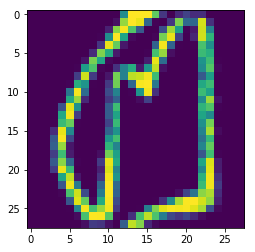

In [123]:
plt.imshow(old_im[2])

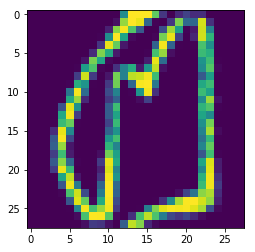

In [124]:
plt.imshow(im[2])

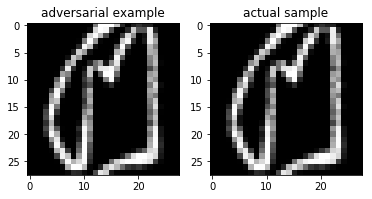

In [130]:
#these ae just snippet tests they don't mean anything now
subplot(1,2,1)
title('adversarial example')
imshow(im[2],cmap='gray')
subplot(1,2,2)
title('actual sample')
imshow(old_im[2],cmap='gray')

accuracy of the network on the 10000 test images:1.12 %


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [143]:
image1=torch.from_numpy(im[1])
img_t1=image1.reshape(-1,1,28,28).to(device)
outputs=my_model(img_t1)
_,predicted=torch.max(outputs.data,1)
print(predicted)

image2=torch.from_numpy(old_im[1])
img_t2=image2.reshape(-1,1,28,28).to(device)
outputs=my_model(img_t2)
_,predicted=torch.max(outputs.data,1)
print(predicted)

tensor([9], device='cuda:0')
tensor([9], device='cuda:0')


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
